In [93]:
import importlib
importlib.reload(pw)

<module 'features_pairwise' from '/home/jacob/JUPYTER PROJECTS/ML/project/features_pairwise.py'>

In [30]:
import features_nodewise as nw
import features_pairwise as pw
import preprocessing as prep

import random
import numpy as np
import igraph
from sklearn import preprocessing
import nltk
import csv
from functools import reduce
from sklearn import metrics
from nltk.tokenize import RegexpTokenizer

nltk.download('punkt') # for tokenization
nltk.download('stopwords')
stpwds = set(nltk.corpus.stopwords.words("english"))
stemmer = nltk.stem.PorterStemmer()

with open("./data/train_train_set.csv", "r") as f:
    reader = csv.reader(f)
    training_set  = list(reader)

with open("./data/train_test_set.csv", "r") as f:
    reader = csv.reader(f)
    testing_set  = list(reader)

training_set = [element[0].split(" ") for element in training_set]
to_keep_train = random.sample( range(len(training_set)),k=int(round(len(training_set)*0.05)) )
training_set_reduced = [training_set[i] for i in to_keep_train]

testing_set = [element[0].split(" ") for element in testing_set]
to_keep_test = random.sample( range(len(testing_set)),k=int(round(len(testing_set)*.37)) )
testing_set_reduced = [testing_set[i] for i in to_keep_test]

with open("./data/node_information.csv", "r") as f:
    reader = csv.reader(f)
    node_info  = list(reader)

IDs = [element[0] for element in node_info]
node_dict = prep.to_dict( [element[0] for element in node_info],range(len(node_info)) )
index_dict = prep.to_dict(range(len(IDs)),IDs)

# compute TFIDF vector of each paper
corpus = [element[5] for element in node_info]

t = prep.tfidf(corpus)
l = nw.LSA(t)

true_edges = [(element[0],element[1]) for element in training_set if element[2]=="1"]
no_citation = [(element[0],element[1]) for element in training_set if element[2]=="0"]
edges= [(element[0],element[1]) for element in training_set]

#use reduced training set
# edges = [(element[0],element[1]) for element in training_set_reduced]
# nodes = set([training_set_reduced[i][0] for i in range(len(training_set_reduced))])
# nodes = nodes | set([training_set_reduced[i][1] for i in range(len(training_set_reduced))])
# l1 = [l[node_dict[i]] for i in nodes]

[nltk_data] Downloading package punkt to /home/jacob/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/jacob/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
n_samples: 27770, n_features: 10000
Performing dimensionality reduction using LSA
Explained variance of the SVD step: 19%


In [31]:
kdtree = nw.KDTree(l)
graph = prep.article_graph(IDs,edges)

In [73]:
def weighted_overlap(f,true_pairs,false_pairs):
    true_f_values = [f(p[0],p[1]) for p in true_pairs]
    true_mean = np.mean(true_f_values)
    false_f_values = [f(p[0],p[1]) for p in false_pairs]
    false_mean = np.mean(false_f_values)
    t_true = len(true_f_values)
    t_false = len(false_f_values)
    
    if true_mean>=false_mean:
        m = max(false_f_values)
        #could be improved by iteratively adding instead of redoing len(list) for every val
        f_overlaps = [len([f for f in false_f_values if f>=val]) for val in true_f_values if val<=m]
        f_overlaps = sum(f_overlaps) / ( t_true*t_false )
    else:
        m = min(false_f_values)
        #could be improved by iteratively adding instead of redoing len(list) for every val
        f_overlaps = [len([f for f in false_f_values if f<=val]) for val in true_f_values if val>=m]
        f_overlaps = sum(f_overlaps) / ( t_true*t_false )
    
    return f_overlaps

In [ ]:
    f.extend(pw.Max_Sim(source,target,l,test_graph,node_dict))
    f.extend(pw.Citation_Check(source,target,test_kdtree,l,test_graph,node_dict,index_dict,k=20))
    f.append(pw.peer_popularity(test_graph,source,target))
    f.append(pw.edge_check(source,target,test_graph))
    f.append(pw.LSA_distance(source,target,node_dict,l,metric='COS'))
    f.extend(pw.node_degree(source,target,test_graph))
    f.append(overlap_title)
    f.append(temp_diff)
    f.append(comm_auth)
    temp.append(pw.succ_pred(source,target,graph))

In [104]:
import random
def true_indicator_w_noise(s,t):
    if (s,t) in true_edges and random.random()<0.9: return 1
    else: return 0
    
# 0.05    lambda s,t: pw.Max_Sim(s,t,l,graph,node_dict)[3]
# 0.08    lambda s,t: pw.Citation_Check(s,t,kdtree,l,graph,node_dict,index_dict,k=1000)[0]
# 0.15    lambda s,t: pw.peer_popularity(graph,s,t)
# 1.00    lambda s,t: pw.edge_check(s,t,graph)
# 0.11    lambda s,t: pw.LSA_distance(s,t,node_dict,l)
# 0.15    lambda s,t: pw.node_degree(s,t,graph)[2]
# 0.05    lambda s,t: pw.succ_pred(s,t,graph)[3]
# 0.37    lambda s,t: pw.baseline(s,t,node_dict,node_info)[3] i.e. time diff


score=[]
for n in range(2):
    score.append(weighted_overlap(lambda s,t: pw.Citation_Check(s,t,kdtree,l,graph,node_dict,index_dict,k=1000)[n],random.sample(true_edges,500),random.sample(no_citation,500)))

In [105]:
score

[0.067728, 0.12016]

In [128]:
to_del = []
for i,triple in enumerate(training_set):
    source = triple[0]
    target = triple[1]
    index_source = node_dict[source]
    index_target = node_dict[target]
    source_info = node_info[index_source]
    target_info = node_info[index_target]
    temp_diff = int(source_info[1]) - int(target_info[1])
    if temp_diff<0:
        to_del.append((source,target))

graph.delete_edges(to_del)

In [88]:
def baseline(source_ID,target_ID,node_dict,node_info):
    f=[]
    
    index_source = node_dict[source_ID]
    index_target = node_dict[target_ID]
    source_info = node_info[index_source]
    target_info = node_info[index_target]
    # convert to lowercase and tokenize
    source_title = source_info[2].lower().split(" ")
    # remove stopwords
    source_title = [token for token in source_title if token not in stpwds]
    source_title = [stemmer.stem(token) for token in source_title]

    target_title = target_info[2].lower().split(" ")
    target_title = [token for token in target_title if token not in stpwds]
    target_title = [stemmer.stem(token) for token in target_title]
    source_auth = source_info[3].split(",")
    target_auth = target_info[3].split(",") 

    overlap_title = len(set(source_title).intersection(set(target_title)))
    temp_diff = int(source_info[1]) - int(target_info[1])
    comm_auth = len(set(source_auth).intersection(set(target_auth)))
    
    f.append(len(set(source_title).intersection(set(target_title))))
    f.append(int(source_info[1]) - int(target_info[1]))
    f.append(len(set(source_auth).intersection(set(target_auth))))
    
    return np.array(f)

In [146]:
feature = []
true_labels = []

# for i,triple in enumerate(training_set):
for i,triple in enumerate(training_set):
    f=[]
    source = triple[0]
    target = triple[1]
    index_source = node_dict[source]
    index_target = node_dict[target]
    source_info = node_info[index_source]
    target_info = node_info[index_target]

    # convert to lowercase and tokenize
    source_title = source_info[2].lower().split(" ")
    # remove stopwords
    source_title = [token for token in source_title if token not in stpwds]
    source_title = [stemmer.stem(token) for token in source_title]

    target_title = target_info[2].lower().split(" ")
    target_title = [token for token in target_title if token not in stpwds]
    target_title = [stemmer.stem(token) for token in target_title]

    source_auth = source_info[3].split(",")
    target_auth = target_info[3].split(",") 

    overlap_title = len(set(source_title).intersection(set(target_title)))
    temp_diff = int(source_info[1]) - int(target_info[1])
    comm_auth = len(set(source_auth).intersection(set(target_auth)))
    
    f.extend(pw.Max_Sim(source,target,l,graph,node_dict))
    f.extend(pw.Citation_Check(source,target,kdtree,l,graph,node_dict,index_dict))
    f.append(pw.peer_popularity(graph,source,target))
    f.append(pw.edge_check(source,target,graph))
    f.append(pw.LSA_distance(source,target,node_dict,l,metric='COS'))
    f.extend(pw.node_degree(source,target,graph))
    f.append(len(set(source_title).intersection(set(target_title))))
    f.append(int(source_info[1]) - int(target_info[1]))
    f.append(len(set(source_auth).intersection(set(target_auth))))
    f.extend(pw.succ_pred(source,target,graph))

    feature.append(f)
#     true_labels.append(triple[2])
    
    if i%1000==0:
        print(i)

0


KeyboardInterrupt: 

In [102]:
import pickle
# with open('./features_train/reduced', 'wb') as f:
#     pickle.dump([training_set_reduced,graph,l,kdtree,node_dict,index_dict,true_labels],f)
# with open('./features_train/reduced_features', 'wb') as f:
#     pickle.dump(feature,f)
with open('./features_train/reduced', 'rb') as f:
    training_set_reduced,graph,l,kdtree,node_dict,index_dict,true_labels=pickle.load(f)
with open('./features_train/reduced_features', 'rb') as f:
    features=pickle.load(f)
#order: max_sim,citation_check,peer_popularity,edge_check,lsa_distance,node_degree,title,time,author


In [109]:
features=np.concatenate((features,feature),axis=1)

In [ ]:
from sklearn.preprocessing import normalize
#currently: 0:CC%,1:CC%,2:Max_Sim..6:Max_Sim,7:avg(max_sim),8:overlap_title,9:temp_diff,10:comm_auth
#temp-diff should be normalized or preprocessed
#as should common_auth?

normalized_features = normalize(features,axis=0)
max([features[i][8] for i in range(1000)])

In [111]:
nodes = set([testing_set_reduced[i][0] for i in range(len(testing_set_reduced))])
nodes = nodes | set([testing_set_reduced[i][1] for i in range(len(testing_set_reduced))])
test_l = [l[node_dict[i]] for i in nodes]
test_kdtree = nw.KDTree(test_l)

test_all_edges = [(element[0],element[1]) for element in testing_set_reduced]
test_graph = prep.article_graph(IDs,test_all_edges)

test_features = []
test_true_labels = []

to_del = []
for i,triple in enumerate(testing_set_reduced):
    source = triple[0]
    target = triple[1]
    index_source = node_dict[source]
    index_target = node_dict[target]
    source_info = node_info[index_source]
    target_info = node_info[index_target]
    temp_diff = int(source_info[1]) - int(target_info[1])
    if temp_diff<0:
        to_del.append((source,target))

test_graph.delete_edges(to_del)

temp=[]
for i,triple in enumerate(testing_set_reduced):
    
    source = triple[0]
    target = triple[1]
    index_source = node_dict[source]
    index_target = node_dict[target]
    
    source_info = node_info[index_source]
    target_info = node_info[index_target]

    # convert to lowercase and tokenize
    source_title = source_info[2].lower().split(" ")
    # remove stopwords
    source_title = [token for token in source_title if token not in stpwds]
    source_title = [stemmer.stem(token) for token in source_title]

    target_title = target_info[2].lower().split(" ")
    target_title = [token for token in target_title if token not in stpwds]
    target_title = [stemmer.stem(token) for token in target_title]

    source_auth = source_info[3].split(",")
    target_auth = target_info[3].split(",") 

    overlap_title = len(set(source_title).intersection(set(target_title)))
    temp_diff = int(source_info[1]) - int(target_info[1])
    comm_auth = len(set(source_auth).intersection(set(target_auth)))
    
    f = []
#     f.extend(pw.Max_Sim(source,target,l,test_graph,node_dict))
#     f.extend(pw.Citation_Check(source,target,test_kdtree,l,test_graph,node_dict,index_dict,k=20))
#     f.append(pw.peer_popularity(test_graph,source,target))
#     f.append(pw.edge_check(source,target,test_graph))
#     f.append(pw.LSA_distance(source,target,node_dict,l,metric='COS'))
#     f.extend(pw.node_degree(source,target,test_graph))
#     f.append(overlap_title)
#     f.append(temp_diff)
#     f.append(comm_auth)
    temp.append(pw.succ_pred(source,target,graph))
#     test_features.append(f)
#     test_true_labels.append(triple[2])
    
    if i%1000==0:
        print(i)
        
test_features=np.array(test_features)
test_true_labels=np.array(test_true_labels)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000


In [114]:
import pickle
# with open('./features_test/reduced', 'wb') as f:
#     pickle.dump([testing_set_reduced,test_graph,l,test_kdtree,node_dict,index_dict,test_true_labels],f)
# with open('./features_test/reduced_features', 'wb') as f:
#     pickle.dump(test_features,f)
# order: max_sim,citation_check,peer_popularity,edge_check,lsa_distance,node_degree,title,time,author
with open('./features_test/reduced', 'rb') as f:
    testing_set_reduced,test_graph,l,test_kdtree,node_dict,index_dict,test_true_labels = pickle.load(f)
with open('./features_test/reduced_features', 'rb') as f:
    test_features = pickle.load(f)

In [ ]:
import random
# for citation_check:
# mean of true but removed edges (with 50% edges removed) is 0.031
# mean of no edge pairs (with 50% edges removed) is 0.0003

[pw.Citation_Check(e[0],e[1],kdtree,l,graph,node_dict,index_dict,k=20) for e in random.sample(edges[150000:],20)]
np.mean([pw.Citation_Check(e[0],e[1],kdtree,l,graph,node_dict,index_dict,k=20) for e in random.sample(no_citation,1500)])

#for Max_Sim:
#mean of true... is 1.13
#mean of no edge... is 0.58
a = np.mean([np.mean(pw.Max_Sim(e[0],e[1],l,graph,node_dict)) for e in random.sample(edges[150000:],1500)])
b = np.mean([np.mean(pw.Max_Sim(e[0],e[1],l,graph,node_dict)) for e in random.sample(no_citation,1500)])

In [72]:
#Import libraries:
import numpy as np
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
# from sklearn import cross_validation, 
from sklearn import metrics   #Additional scklearn functions
# from sklearn.grid_search import GridSearchCV   #Perforing grid search

import matplotlib.pylab as plt


def modelfit(alg, features, true_labels,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
#     if useTrainCV:
#         xgb_param = alg.get_xgb_params()
#         xgtrain = xgb.DMatrix(features, label=true_labels)
#         cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
#             metrics='auc', early_stopping_rounds=early_stopping_rounds)
#         alg.set_params(n_estimators=cvresult)
    
    #Fit the algorithm on the data
    alg.fit(features, true_labels,eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(features)
    dtrain_predprob = alg.predict_proba(features)[:,1]
        
    #Print model report:
    print ("\nModel Report")
    print ("Accuracy : %.4g" % metrics.accuracy_score(true_labels, dtrain_predictions))
    print ("AUC Score (Train): %f" % metrics.roc_auc_score(true_labels, dtrain_predprob))
                    
#     feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
#     feat_imp.plot(kind='bar', title='Feature Importances')
#     plt.ylabel('Feature Importance Score')

In [117]:
xgb1 = XGBClassifier(
 learning_rate =0.01,
 max_depth=8,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
)

modelfit(xgb1, features, true_labels,useTrainCV=True)

preds = xgb1.predict(test_features)
acc = metrics.accuracy_score(list(map(int,test_true_labels)), list(map(int,preds)))
f1 = metrics.f1_score(list(map(int,test_true_labels)), list(map(int,preds)))
print('acc:',acc,'f1:',f1)


Model Report
Accuracy : 0.919
AUC Score (Train): 0.974854
acc: 0.7687358565913831 f1: 0.7315339445760791


In [108]:
np.argsort(list(map(lambda x: abs(x),model.coef_)))

array([[ 6,  7, 11,  3, 13, 14, 16,  4,  0, 12,  2,  1,  5, 15, 17,  9,
         8, 10]])

In [109]:
model.coef_

array([[  0.20162231,   0.34606133,   0.33702178,   0.05291719,
          0.170514  ,   0.5783737 ,   0.        ,   0.        ,
          5.77135701,   5.11529972, -11.41306671,   0.030921  ,
          0.31166434,   0.09525976,   0.12434175,   0.8338475 ,
         -0.14991541,   1.32397697]])

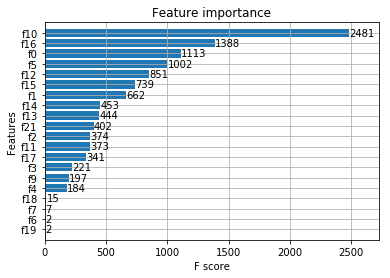

In [121]:
fig, ax = plt.subplots()
xgb.plot_importance(xgb1, max_num_features=50, height=0.8, ax=ax)
plt.show()
##order: 0-5max_sim,6-7citation_check,8peer_popularity,9edge_check,
#10lsa_distance,11-14node_degree,15title,16time,17author


In [92]:
short_features=features[:,[0,  2,  1, 15, 17,  9,8, 10]]
short_test_features = test_features[:,[0,  2,  1, 15, 17,  9,8, 10]]

In [114]:
from sklearn import svm

classifier = svm.LinearSVC()
##order: 0-5max_sim,6-7citation_check,8peer_popularity,9edge_check,
#10lsa_distance,11-14node_degree,15title,16time,17author

# train
classifier.fit(features[:,[8,15,16,17]], true_labels)
preds= list(classifier.predict(test_features[:,[8,15,16,17]]))
acc = metrics.accuracy_score(list(map(int,test_true_labels)), list(map(int,preds)))
f1 = metrics.f1_score(list(map(int,test_true_labels)), list(map(int,preds)))
print('acc:',acc,'f1:',f1)

acc: 0.6664595997692683 f1: 0.6798960950474812


/home/jacob/miniconda3/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [119]:
from sklearn.linear_model import LogisticRegression as lr
model = lr(penalty='l1',solver='liblinear').fit(features,true_labels)
cf = model.get_params()
preds = list(model.predict(test_features))
acc = metrics.accuracy_score(list(map(int,test_true_labels)), list(map(int,preds)))
f1 = metrics.f1_score(list(map(int,test_true_labels)), list(map(int,preds)))
print('acc:',acc,'f1:',f1)

acc: 0.6821671029862004 f1: 0.5886879127189205


In [ ]:
from sklearn.neighbors import KNeighborsClassifier

nNhbr = KNeighborsClassifier()
nNhbr.fit(features,true_labels) # do Ytrain.ravel() for length one Y values
preds = nNhbr.predict(test_features)
acc = metrics.accuracy_score(list(map(int,test_true_labels)), list(map(int,preds)))
f1 = metrics.f1_score(list(map(int,test_true_labels)), list(map(int,preds)))
print('acc:',acc,'f1:',f1)

In [ ]:
from sklearn.tree import DecisionTreeClassifier

dTree = DecisionTreeClassifier()
dTree.fit(features,true_labels) # do Ytrain.ravel() for length one Y values
preds = dTree.predict(test_features)
acc = metrics.accuracy_score(list(map(int,test_true_labels)), list(map(int,preds)))
f1 = metrics.f1_score(list(map(int,test_true_labels)), list(map(int,preds)))
print('acc:',acc,'f1:',f1)

In [ ]:
import tensorflow as tf
import numpy as np
import time
import math


class Class_Net():

    def __init__(self, learning_rate=0.001, batch_size=60):
        ''' initialize the classifier with default (best) parameters '''
        tf.reset_default_graph()
        self.alpha = learning_rate
        self.beta = batch_size
        self.warm = False

    def fit(self,X,Y,warm_start=True,n_epochs=50):
        ''' train the network, and if warm_start, then do not reinit. the network
            (if it has already been initialized)
        '''
        self.epochs=n_epochs

        self.n_batch = int(len(X)/self.beta)
        
        if warm_start==False or self.warm==False:
            self.x = tf.placeholder(tf.float32,shape=[None,len(X[0])])
            self.y = tf.placeholder(tf.float32,shape=[None,1])
            
            self.wZero = tf.get_variable('wZero',shape=[len(X[0]),50],initializer=tf.glorot_uniform_initializer())
            self.bZero = tf.Variable(tf.zeros([50]))

            self.wOne = tf.get_variable('wOne',shape=[50,1],initializer=tf.glorot_uniform_initializer())
            self.bOne = tf.Variable(tf.zeros([1]))
            self.keep_prob = 0.9
            self.drop_out = tf.nn.dropout(self.x, self.keep_prob)
            self.model = tf.nn.sigmoid(tf.matmul(tf.nn.relu(tf.matmul(self.drop_out, self.wZero) 
                                              + self.bZero),self.wOne)+self.bOne)
            self.cost = tf.losses.log_loss(self.y,self.model)
            
#             self.optimizer = tf.train.GradientDescentOptimizer(self.alpha).minimize(self.cost)
            self.optimizer = tf.train.AdamOptimizer(learning_rate=self.alpha).minimize(self.cost)

            #without dropout
#             self.model = tf.matmul(tf.nn.relu(tf.matmul(self.x, self.wZero) + self.bZero),self.wOne)+self.bOne

    
            self.saver = tf.train.Saver()
            self.init = tf.global_variables_initializer()
            
        with tf.Session() as sess:
            if warm_start==False or self.warm==False:
                sess.run(self.init)
            else:
                self.saver.restore(sess, './tempVariables.ckpt')
            for epoch in range(self.epochs):
                self.avg_cost = 0
                for i in range(self.n_batch):
                    _, self.c = sess.run([self.optimizer,self.cost], feed_dict={self.x: X[i*self.beta:min([(i+1)*
                                    self.beta,len(X)]),:],self.y:Y[i*self.beta:min([(i+1)*self.beta,len(X)])]})
                    
                    self.avg_cost = self.avg_cost+np.mean(self.c)/self.n_batch
                print("Epoch:", '%s' % (epoch+1), "cost=", "%s"% (self.avg_cost))
            self.saver.save(sess,'./tempVariables.ckpt')
            
        self.warm = True
        
        return self
    
    def predict_proba(self,X):
        ''' return a matrix P where P[i,j] = P(Y[i,j]=1), 
        for all instances i, and labels j. '''

        with tf.Session() as sess:
            self.saver.restore(sess, './tempVariables.ckpt')
            self.preds = sess.run(tf.nn.softmax(self.model), feed_dict={self.x: X}) 
        return self.preds
    
    def predict(self,X):
        ''' return a matrix of predictions for X '''
        return (self.predict_proba(X) >= 0.5).astype(int)
    
    


In [ ]:
net = Class_Net(learning_rate=0.01,batch_size=250)
net.fit(features,list(map(lambda x: [x],true_labels)),n_epochs=35)
preds=net.predict(test_features)
acc = metrics.accuracy_score(list(map(int,test_true_labels)), list(map(int,preds)))
f1 = metrics.f1_score(list(map(int,test_true_labels)), list(map(int,preds)))
print('acc:',acc,'f1:',f1)